This script contains some improvement from train.ipynb by default:
* much few layers, heads, and embedding dimension to reduce the model size
* dataloader v2 which uses a custom tokenizer (again to reduce model size)
* no positional embeddings (to reduce model complexity)
* weight tying (to reduce model size)


We implemented a few things here first and not before:
* validation losses
* increased the model size to be just below 30M parameters
* reduced the amount of data trained with to keep the training (wall) time consistent
* made graph more informative

This script contains a couple improvements from train2.ipynb:
* gradient accumulation is enabled
* the dataloader chunks from the start of an example up to the max_length or the endoftext token

This contains some changes from train3.ipynb:
* an accuracy metric has been implemented
* one cycle learning rate schedule is being used
* weight tying is disabled

This contains some improvements from train4.ipynb: just that the attention module used uses pytorchs implementation for sdpa. This also uses a text generation function to display the capabilities of the trained model.

In [1]:
import socket

In [2]:
socket.gethostname()

'LAPTOP-V1QE676P'

In [3]:
GPT_CONFIG_30M = {
    "vocab_size": 30002,
    "context_length": 256,
    "emb_dim": 512,
    "n_heads": 4,
    "n_layers": 4,
    "drop_rate": 0.0,
    "qkv_bias": False,
    "weight_tying": True,
    "no_pos_emb": True
}

In [4]:
GPT_CONFIG_60M = {
    "vocab_size": 30002,
    "context_length": 512,
    "emb_dim": 512,
    "n_heads": 8,
    "n_layers": 8,
    "drop_rate": 0.0,
    "qkv_bias": False,
    "weight_tying": False,
    "no_pos_emb": True
}

In [5]:
import socket
hostname = socket.gethostname().lower()
if "laptop" in hostname:
    GPT_CONFIG = GPT_CONFIG_30M
else:
    GPT_CONFIG = GPT_CONFIG_60M

In [6]:
import torch.nn as nn
import torch

torch.set_float32_matmul_precision('medium')

In [7]:
trainer_config = {
    "dataset_scale": 300,
    "batch_size": 32 if "laptop" in hostname else 32,
    "epochs": 1,
    "train_file_loc": "../data/TinyStories/TinyStoriesV2-GPT4-train.txt",
    "valid_file_loc": "../data/TinyStories/TinyStoriesV2-GPT4-valid.txt",
    "num_workers": 11 if "laptop" in hostname else 23,
    "max_lr": 1e-3
}
trainer_config["grad_batches"] = 256 // trainer_config["batch_size"]

In [34]:
from torch.optim.lr_scheduler import OneCycleLR
from components.data import create_dataloader_v3
import lightning as L

class LitGPTModel(L.LightningModule):
    def __init__(self, GPTModel, trainer_config, gpt_config):
        super().__init__()
        self.gpt_config = gpt_config
        self.trainer_config = trainer_config
        self.model = GPTModel

        self.train_accuracy = []
        self.val_accuracy = []
        self.train_losses = []
        self.val_losses = []
        self.val_steps = []
        self.learning_rates = []
        self.batch_step = 0

    def _accuracy(self, output, expected):
        total_matching = (torch.argmax(output, dim=-1) == expected).sum().item()
        total_numel = expected.numel()
        return total_matching / total_numel

    def training_step(self, batch, batch_idx):
        self.batch_step += 1
        x, y = batch
        logits = self.model(x)

        accuracy = self._accuracy(logits, y)
        self.log("accuracy", accuracy, prog_bar=True, on_step=True, on_epoch=True)
        self.train_accuracy.append(accuracy)

        loss = self.loss(logits, y)
        self.log("loss", loss, prog_bar=True, on_step=True, on_epoch=True)
        self.train_losses.append(loss.item())

        current_lr = self.optimizers().param_groups[0]["lr"]
        self.learning_rates.append(current_lr)

        return loss

    def validation_step(self, batch, batch_idx):
        self.val_steps.append(self.batch_step)
        x, y = batch

        logits = self.model(x)

        accuracy = self._accuracy(logits, y)
        self.log("val_accuracy", accuracy, prog_bar=True, on_step=True, on_epoch=True)
        self.val_accuracy.append(accuracy)

        loss = self.loss(logits, y)
        self.log("val_loss", loss, prog_bar=True, on_step=True, on_epoch=True)
        self.val_losses.append(loss.item())
        
        return loss

    def loss(self, output, expected):
        loss = nn.functional.cross_entropy(
            output.flatten(0, 1), expected.flatten()
        )
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self.parameters(), lr=self.trainer_config["max_lr"], weight_decay=0.1
        )

        scheduler = OneCycleLR(
            optimizer,
            max_lr=self.trainer_config["max_lr"],
            total_steps=self.trainer.estimated_stepping_batches,
        )
        lr_scheduler_config = {
            "scheduler": scheduler,
            "interval": "step",
            "monitor": "loss"
        }

        return {
            "optimizer": optimizer,
            "lr_scheduler": lr_scheduler_config
        }

    def setup(self, stage):
        # todo, build model in this function
        with open(self.trainer_config["train_file_loc"], encoding="utf-8") as f:
            self.train_text = f.read()

            text_len = len(self.train_text)
            dataset_scale = self.trainer_config["dataset_scale"]
            self.train_text = self.train_text[:text_len // dataset_scale]

        with open(self.trainer_config["valid_file_loc"], encoding="utf-8") as f:
            self.valid_text = f.read()

            train_len = len(self.train_text)
            self.valid_text = self.valid_text[:train_len // 10]
        
    def _create_dataloader(self, text, train_loader):
        return create_dataloader_v3(
            text,
            batch_size=self.trainer_config["batch_size"],
            max_length=self.gpt_config["context_length"],
            stride=self.gpt_config["context_length"],
            drop_last=train_loader,
            shuffle=train_loader,
            num_workers=self.trainer_config["num_workers"]
        )

    def train_dataloader(self):
        # consider setting self.train_text = None if memory consumption is an issue
        train_loader = self._create_dataloader(
            self.train_text,
            train_loader=True
        )
        return train_loader

    def val_dataloader(self):
        return self._create_dataloader(
            self.valid_text,
            train_loader=False
        )


In [35]:
from components.gptmodel import GPTModel_v2
model = GPTModel_v2(GPT_CONFIG)
litmodel = LitGPTModel(
    model,
    trainer_config,
    GPT_CONFIG
)

In [36]:
%%time

trainer = L.Trainer(
    max_epochs=trainer_config["epochs"],
    enable_progress_bar=True,
    accumulate_grad_batches=trainer_config["grad_batches"]
)
trainer.fit(model=litmodel)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.

  | Name  | Type        | Params | Mode 
----------------------------------------------
0 | model | GPTModel_v2 | 28.1 M | train
----------------------------------------------
28.1 M    Trainable params
0         Non-trainable params
28.1 M    Total params
112.506   Total estimated model params size (MB)
64        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                             | 0/? [00:00<?,…

Training: |                                                                                    | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

`Trainer.fit` stopped: `max_epochs=1` reached.


CPU times: user 1min 52s, sys: 4.18 s, total: 1min 56s
Wall time: 1min 57s


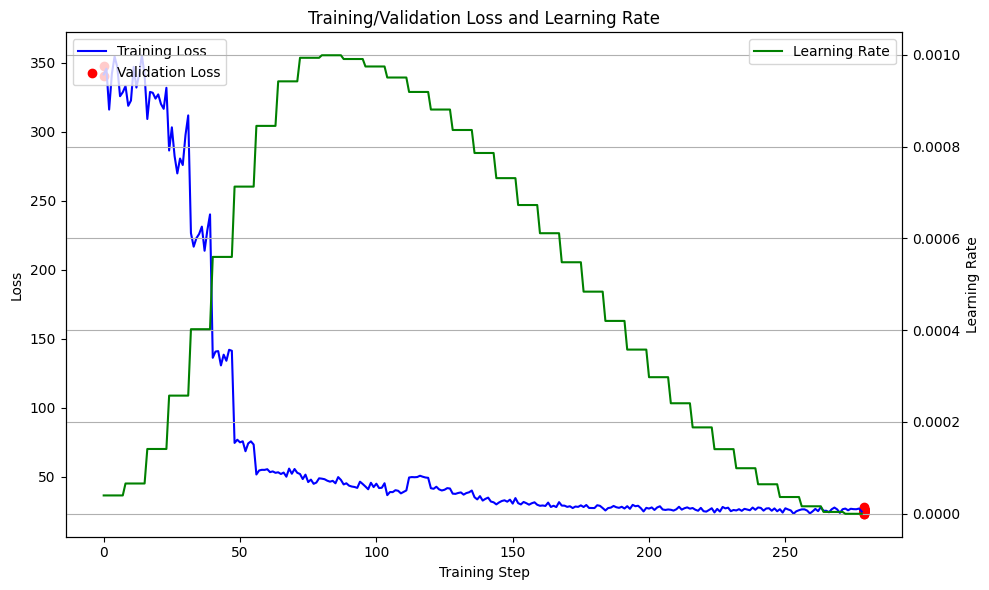

In [37]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(litmodel.train_losses, label="Training Loss", color="blue")
ax1.scatter(litmodel.val_steps, litmodel.val_losses, label="Validation Loss", color="red")
ax1.set_xlabel("Training Step")
ax1.set_ylabel("Loss")
ax1.legend(loc="upper left")

ax2 = ax1.twinx()
ax2.plot(litmodel.learning_rates, label="Learning Rate", color="green")
ax2.set_ylabel("Learning Rate")
ax2.legend(loc="upper right")

plt.title("Training/Validation Loss and Learning Rate")
plt.tight_layout()
plt.grid(True)
plt.show()

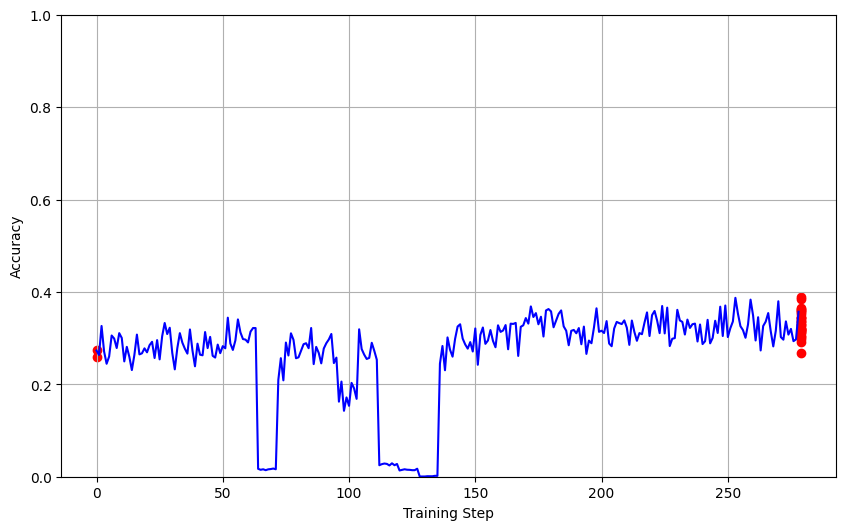

In [38]:
plt.figure(figsize=(10, 6))
plt.plot(litmodel.train_accuracy, color="blue")
plt.scatter(litmodel.val_steps, litmodel.val_accuracy, color="red")
plt.xlabel("Training Step")
plt.ylabel("Accuracy")
plt.grid(True)
plt.ylim(0, 1)
plt.show()

In [13]:
from tokenizers import Tokenizer

In [14]:
tokenizer = Tokenizer.from_file("./TinyStories_tokenizer.json")

In [15]:
from tokenizers import decoders
tokenizer.decoder = decoders.WordPiece()

In [16]:
from components.generatetext import generate_text

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
litmodel.model.to(device)

GPTModel_v2(
  (tok_emb): Embedding(30002, 512)
  (pos_emb): Embedding(256, 512)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock_v2(
      (att): MultiHeadAttention_v2(
        (W_query): Linear(in_features=512, out_features=512, bias=False)
        (W_key): Linear(in_features=512, out_features=512, bias=False)
        (W_value): Linear(in_features=512, out_features=512, bias=False)
        (out_proj): Linear(in_features=512, out_features=512, bias=True)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=512, out_features=2048, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=2048, out_features=512, bias=True)
        )
      )
      (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock_v2(
     

In [18]:
%%time
litmodel.eval()
starting_text = "Tom and Jane are friends. One day, Jane goes to Tom’s house. Tom has a big pot of soup. He wants to share it with Jane. “Jane, do you want some soup?” Tom asks. “Yes, please. It looks yummy,” Jane says. Tom pours some soup into two bowls. He gives one bowl to Jane. Jane takes a spoonful of soup, but then she makes a face. The soup is"
text = generate_text(litmodel.model, tokenizer, starting_text, 512, device, topk=3, temperature=1)
print("text: ", text)

text:  Tom and Jane are friends. One day, Jane goes to Tom ’ s house. Tom has a big pot of soup. He wants to share it with Jane. “ Jane, do you want some soup?” Tom asks. “ Yes, please. It looks yummy,” Jane says. Tom pours some soup into two bowls. He gives one bowl to Jane. Jane takes a spoonful of soup, but then she makes a face. The soup is is is is is wobbly wobbly bib bib bib bib Haha Haha mouse Matches alleyway alleyway Creamy Creamy Creamy Creamy Creamy Creamy Creamy Creamy demean demean demean wonder wonder wonder adding adding adding adding adding Spark Spark Spark Spark Spark Spark adding adding adding adding wonder?',?',?',?',?',?',?', wonder wonder wonder wonder wonder wonder wonder?', savoring Vet clubhouse clubhouse clubhouse clubhouse clubhouse clubhouse clubhouse clubhouse miraculously miraculously ê ê ê miraculously miraculously miraculously miraculously clubhouse fashioned fashioned fashioned fashioned fashioned fashioned turquoise Eskimos Eskimos Eskimos Eskimos Esk

In [19]:
%%time
litmodel.eval()
starting_text = "Tom and Jane are friends. One day, Jane goes to Tom’s house. Tom has a big pot of soup. He wants to share it with Jane. “Jane, do you want some soup?” Tom asks. “Yes, please. It looks yummy,” Jane says. Tom pours some soup into two bowls. He gives one bowl to Jane. Jane takes a spoonful of soup, but then she makes a face. The soup is"
text = generate_text(litmodel.model, tokenizer, starting_text, 512, device, topk=3, temperature=1)
print("text: ", text)

text:  Tom and Jane are friends. One day, Jane goes to Tom ’ s house. Tom has a big pot of soup. He wants to share it with Jane. “ Jane, do you want some soup?” Tom asks. “ Yes, please. It looks yummy,” Jane says. Tom pours some soup into two bowls. He gives one bowl to Jane. Jane takes a spoonful of soup, but then she makes a face. The soup is is is Shiney Shiney cere Aar resent resent colle Cinderella Cinderella Cinderella Cinderella Cinderella zig zig needing cheddar vul diction diction diction diction diction diction impact impact impact impact impact impact things things things things things things things things pecked pecked pecked pecked pecked pecked things things things things things things things things things pecked things pecked pecked things pecked pecked greatness greatness greatness greatness greatness greatness Frame Frame Frame Frame strike strike strike Frame Frame ult ult ult ult Nicki lica athlet athlet athlet athlet athlet athlet athlet guides sunbathe sunbathe sun

In [20]:
%%time
litmodel.eval()
starting_text = "Tom and Jane are friends. One day, Jane goes to Tom’s house. Tom has a big pot of soup. He wants to share it with Jane. “Jane, do you want some soup?” Tom asks. “Yes, please. It looks yummy,” Jane says. Tom pours some soup into two bowls. He gives one bowl to Jane. Jane takes a spoonful of soup, but then she makes a face. The soup is"
text = generate_text(litmodel.model, tokenizer, starting_text, 512, device, topk=3, temperature=1)
print("text: ", text)

text:  Tom and Jane are friends. One day, Jane goes to Tom ’ s house. Tom has a big pot of soup. He wants to share it with Jane. “ Jane, do you want some soup?” Tom asks. “ Yes, please. It looks yummy,” Jane says. Tom pours some soup into two bowls. He gives one bowl to Jane. Jane takes a spoonful of soup, but then she makes a face. The soup is is is is is is is is is is is is is is is is is is piece ripping ripping ripping ripping ripping ripping ripping Anty Anty Anty Anty Anty Mishu Mishu playdates playdates playdates playdates playdates playdates playdates playdates Mom Mom Mom Mom FooFoo FooFoo FooFoo FooFoo FooFoo FooFoo Papaya Papaya Gemma Gemma clanked tuss tuss tuss tuss tuss tuss tuss tuss Respec Respec Respec tuss tuss tuss tuss tuss tuss Hig Hig Hig delicous fring fring Thermie soups soups soups soups soups soups soups soups soups soups soups soups soups soups beverages beverages beverages beverages beverages beverages beverages beverages beverages beverages beverages abrup

In [21]:
%%time
litmodel.eval()
starting_text = "Tom and Jane are friends. One day, Jane goes to Tom’s house. Tom has a big pot of soup. He wants to share it with Jane. “Jane, do you want some soup?” Tom asks. “Yes, please. It looks yummy,” Jane says. Tom pours some soup into two bowls. He gives one bowl to Jane. Jane takes a spoonful of soup, but then she makes a face. The soup is"
text = generate_text(litmodel.model, tokenizer, starting_text, 512, device, topk=3, temperature=1)
print("text: ", text)

text:  Tom and Jane are friends. One day, Jane goes to Tom ’ s house. Tom has a big pot of soup. He wants to share it with Jane. “ Jane, do you want some soup?” Tom asks. “ Yes, please. It looks yummy,” Jane says. Tom pours some soup into two bowls. He gives one bowl to Jane. Jane takes a spoonful of soup, but then she makes a face. The soup is is is Shiney Shiney Shiney Shiney cere cere Aar Aar resent resent resent Truckie Truckie Truckie Truckie Truckie Truckie Truckie Truckie Truckie Truckie Truckie Truckie ugly ugly ugly ugly ugly ugly ugly Pandy Pandy Pandy ugly peer peer peer peer peer peer ars ars Score Score Grr Grr chord chord chord chord chord chances chances chances chances chances chances chances Scooby Scooby Rip Rip Rip FUN Birdie Birdie Birdie Birdie Birdie Snowflake etc etc etc Timi Timi prying chanic cobs Jupiter cobs cobs cobs cobs raine detail detail detail detail detail detail detail detail detail detail detail detail detail detail detail detail detail detail detail